In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

from PIL import Image

import torch
from torchvision import transforms

# OpenCLIP
import open_clip
from open_clip import tokenizer

# 事前学習済みモデルを確認
open_clip.list_pretrained()

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[('RN50', 'openai'),
 ('RN50', 'yfcc15m'),
 ('RN50', 'cc12m'),
 ('RN101', 'openai'),
 ('RN101', 'yfcc15m'),
 ('RN50x4', 'openai'),
 ('RN50x16', 'openai'),
 ('RN50x64', 'openai'),
 ('ViT-B-32', 'openai'),
 ('ViT-B-32', 'laion400m_e31'),
 ('ViT-B-32', 'laion400m_e32'),
 ('ViT-B-32', 'laion2b_e16'),
 ('ViT-B-32', 'laion2b_s34b_b79k'),
 ('ViT-B-32', 'datacomp_xl_s13b_b90k'),
 ('ViT-B-32', 'datacomp_m_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_clip_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_laion_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_image_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_text_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_basic_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_s128m_b4k'),
 ('ViT-B-32', 'datacomp_s_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_clip_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_laion_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_image_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_text_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_basic_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_s13m_b4k'),
 ('ViT-

In [2]:
# モデルの読み込み（初回はダウンロード）
model, _, preprocess = open_clip.create_model_and_transforms(
  'convnext_base_w', pretrained='laion2b_s13b_b82k_augreg')
model.eval() # 推論モードへ

# print('### model:\n', model) # モデルの詳細な構造
print('### Model parameters:', f'{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}')
print('### preprocess:\n', preprocess) # 画像の前処理

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


### Model parameters: 179,385,345
### preprocess:
 Compose(
    Resize(size=256, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(256, 256))
    <function _convert_to_rgb at 0x7f63329a48b0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)


In [3]:
descriptions = {
  'penguin': 'Penguins running by the sea',
  'duck': 'Ducklings running on the lawn',
  'dog': 'Shiba-inu in the grass',
  'bridge': 'A bridge crowded with people',
  'arch': 'A large arch made of stone',
  'harbor': 'Ships floating in the harbor',
}

orig_images = [
  Image.open(f'{k}.jpg') for k in descriptions.keys()
]
orig_texts = list(descriptions.values())

# CLIPへの入力用テンソル
image_input = torch.stack([preprocess(img) for img in orig_images])
text_tokens = tokenizer.tokenize(orig_texts)

# 可視化用にリサイズと切り出し処理を定義
trans = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(256)
])

# 画像とテキストの例
plt.figure(figsize=(3, 3))
idx = 0
plt.imshow(trans(orig_images[idx]))
plt.show()
print('orig text:\n', orig_texts[idx])
print('tokenized:\n', text_tokens[idx])
print('length of text', len(text_tokens[idx]))

FileNotFoundError: [Errno 2] No such file or directory: 'penguin.jpg'

In [5]:
with torch.no_grad(): # 勾配計算オフ
  # エンコーダによる埋め込み
  image_features = model.encode_image(image_input).float()
  text_features = model.encode_text(text_tokens).float()
  print(image_features.shape)
  print(text_features.shape)
  # ノルムで割って正規化し単位ベクトルへ
  image_features /= image_features.norm(dim=-1, keepdim=True)
  text_features /= text_features.norm(dim=-1, keepdim=True)

  # cos類似度：正規化された単位ベクトル同士の内積
  similarity = text_features @ image_features.T

torch.Size([6, 640])
torch.Size([6, 640])


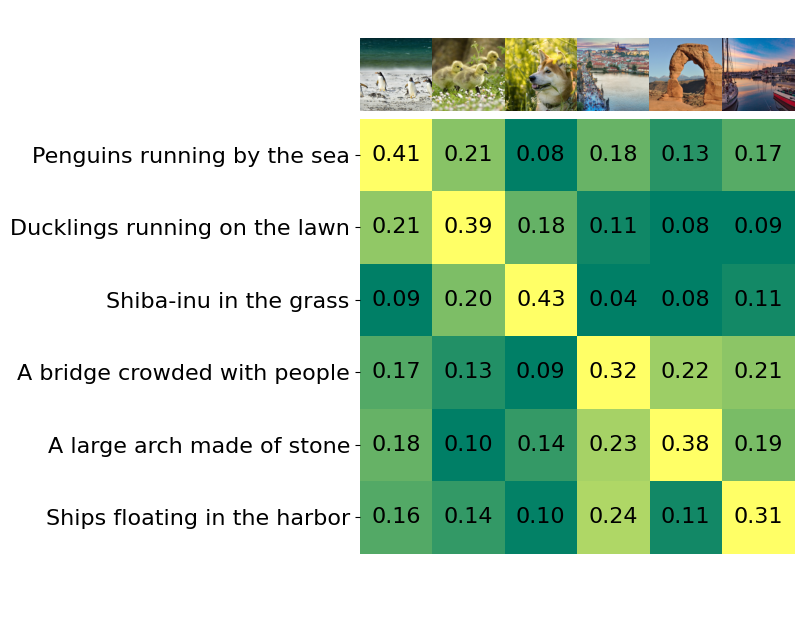

In [6]:
count = len(descriptions) # 入力ペアの数
plt.figure(figsize=(12, 8))

# 類似度行列を可視化
plt.imshow(similarity, vmin=0.1, vmax=0.3, cmap='summer')

# テキストを左に表示
plt.yticks(range(count), orig_texts, fontsize=16)
plt.xticks([])
# 画像（中央切り出し後）を上に配置
for i, img in enumerate(orig_images): # extent: left, right, bottom, top
  plt.imshow(trans(img), extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin='lower')

# 類似度をテキストで重畳表示
for x in range(similarity.shape[1]):
  for y in range(similarity.shape[0]):
    plt.text(x, y, f'{similarity[y, x]:.2f}', size=16, ha='center', va='center')
# 枠を消す
for side in ['left', 'top', 'right', 'bottom']:
  plt.gca().spines[side].set_visible(False)
# 画像が入るように適切に範囲を変更
plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])
plt.show()

In [7]:
# あらかじめクラス名の単語からテキスト特徴を取得しておく
labels = ['dog', 'cat', 'alpaca', 'llama', 'vicuna', 'camel', 'giraffe', 'rainbow', 'piano']
text_tokens = tokenizer.tokenize(labels)
# text_tokens = tokenizer.tokenize(['A photo of ' + lbl for lbl in labels])
with torch.no_grad():
  text_features = model.encode_text(text_tokens)
  text_features /= text_features.norm(dim=-1, keepdim=True)

def recognize(image_pil, text_features):
  """1枚の画像を分類"""
  image_input = preprocess(image_pil).unsqueeze(0) # 1枚だけのバッチに
  # print(image_input.shape) # サイズを確認
  with torch.no_grad():
    image_features = model.encode_image(image_input)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    # 類似度計算
    text_sims = (image_features @ text_features.T).cpu().numpy()[0]
  return text_sims

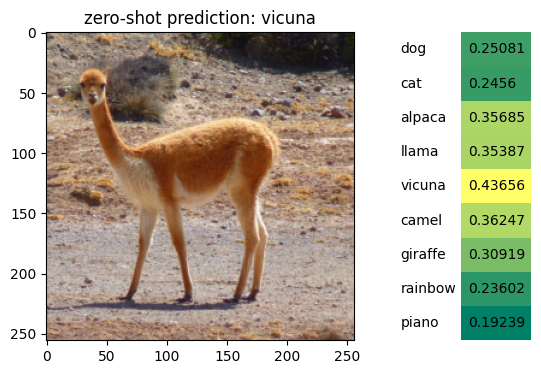

In [9]:
# 画像を認識（テキスト特徴との類似度計算）
image = Image.open('image.jpg')
text_sims = recognize(image, text_features)

# 画像と認識結果を表示する
fig, ax = plt.subplots(1, 2, figsize=(7, 4), width_ratios=(6, 1))
ax[0].imshow(trans(image))
ax[0].set_title(f'zero-shot prediction: {labels[text_sims.argmax()]}')
sims = np.round(text_sims, 5).reshape(-1, 1) # 列方向へ
clrs = (sims - sims.min())/(sims.max()-sims.min()) # 色表示のために正規化
tbl = ax[1].table(cellText=sims, rowLabels=labels, loc='center',
                  cellLoc='left', cellColours=plt.cm.summer(clrs))
ax[1].axis('off')
for pos, cell in tbl.get_celld().items():
  cell.set_height(1/len(labels)) # セルの高さを調整
  cell.set_edgecolor('none') # 枠を消す
plt.show()

In [10]:
# あらかじめ画像特徴を取得しておく
image_paths = glob.glob('images/*.jpg')
orig_images = [Image.open(path) for path in image_paths]
image_input = torch.stack([preprocess(img) for img in orig_images])
with torch.no_grad():
  image_features = model.encode_image(image_input).float()
  image_features /= image_features.norm(dim=-1, keepdim=True)

def retrieve(text, image_features):
  """テキストと近い画像のインデックスを見つける"""
  text_tokens = tokenizer.tokenize([text]) # 1つだけのテキストからなるバッチを入力
  # print(text_tokens.shape)
  # エンコーダによる埋め込み
  with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
    # 類似度計算
    image_sims = (text_features @ image_features.T).cpu().numpy()[0]
  # 降順ソート後のインデックスと類似度を返す
  return np.argsort(image_sims)[::-1], np.sort(image_sims)[::-1]

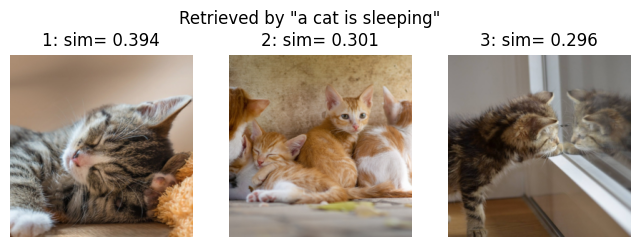

In [11]:
# テキストと近い画像のインデックスを見つける
query = 'a cat is sleeping'
# query = 'alpacas just sheared'
# query = 'birds near the sea'
retidx, sims = retrieve(query, image_features)

# テキストと類似する3番目の画像まで表示
fig, ax = plt.subplots(1, 3, figsize=(8, 4))
for i in range(3):
  idx = retidx[i]
  ax[i].imshow(trans(orig_images[idx]))
  ax[i].set_title(f'{i + 1}: sim= {sims[i]:.3f}')
  ax[i].axis('off')
fig.suptitle(f'Retrieved by "{query}"')
fig.subplots_adjust(bottom=0.4)
plt.show()